In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
from scipy.stats import poisson, norm


In [4]:

# Set random seed for reproducibility
np.random.seed(42)

# Load the data from the specified .npz file
file = np.load("..\\data\\2024-03-29-data.npz")

# Extract the necessary components from the file
data = file['data']               # Raw Data
mz_values = file['mz_values']     # Corresponding mz-values
image_size = file['image_size']   # Size of the image
mz_picks = file['mz_picks']       # Selected mz-ids
num = file['num']                 # Number of picks

In [71]:
def normalizeData(data):
    # Normalize the data
    row_max = data.max(axis=1)
    n_data = data / row_max[:, np.newaxis]
    n_data = n_data.T
    return n_data, row_max

def denormalizeData(n_data, row_max):
    # Denormalize the data
    denormalized_data = n_data * row_max[:, np.newaxis]
    return denormalized_data


def plotHistogram(data, bins='auto'):
    plt.figure(figsize=(15, 10))
    
    # Plotting the histogram of the input data
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black', density=True, label='Data Histogram')
    
    # Generate and plot the selected distribution
    x_values = np.linspace(min(data), max(data), 1000)

    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate the normal PDF
    normal_pdf = norm.pdf(x_values, mean, std)
    plt.plot(x_values, normal_pdf, label=f'Normal Distribution (mean={mean}, std={std})', color='red')

    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.legend()

    # Display the plot
    plt.show()

def generate_matrix(mean, std, shape=(4, 4)):
    """
    Generates a matrix of the given shape with values between 0 and 1,
    and specified mean and standard deviation.
    
    Args:
    - mean (float): Desired mean of the matrix.
    - std (float): Desired standard deviation of the matrix.
    - shape (tuple): Shape of the matrix (default is 4x4).
    
    Returns:
    - matrix (numpy array): A matrix with values between 0 and 1, mean and std.
    """
    # Generate a normal distribution with the specified mean and std
    matrix = np.random.normal(loc=mean, scale=std, size=shape)
    
    # Clip the values to ensure they are between 0 and 1
    matrix = np.clip(matrix, 0, 1)
    
    # Verify the mean and std
    print(f"Generated matrix has mean: {np.mean(matrix):.10f} and std: {np.std(matrix):.10f}")
    
    return matrix

def sample_nonzero_values(matrix, sample_ratio):
    """
    Randomly samples a ratio of the non-zero values in the matrix and keeps them,
    while setting the rest of the values to zero.
    
    Args:
    - matrix (numpy array): Input matrix with values.
    - sample_ratio (float): Ratio of non-zero values to keep (between 0 and 1).
    
    Returns:
    - sampled_matrix (numpy array): Matrix with sampled non-zero values.
    """
    # Find the indices of non-zero values in the matrix
    non_zero_indices = np.argwhere(matrix != 0)
    
    # Number of non-zero values to sample
    num_non_zero = len(non_zero_indices)
    num_to_sample = int(np.ceil(sample_ratio * num_non_zero))
    
    # Randomly select indices to keep
    sampled_indices = np.random.choice(np.arange(num_non_zero), size=num_to_sample, replace=False)
    
    # Create a new matrix with all values set to zero initially
    sampled_matrix = np.zeros_like(matrix)
    
    # Retain the sampled values in the new matrix
    for idx in sampled_indices:
        row, col = non_zero_indices[idx]
        sampled_matrix[row, col] = matrix[row, col]
    
    return sampled_matrix


# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped

def massbinImageComparisonGPT(massbin_of_interest, data, clipped_data, clipped_sampled_data, colormap='cubehelix'):
    # Set the base colormap
    base_cmap = plt.get_cmap(colormap)

    # Create a new colormap with red for zero values
    new_cmap = mcolors.ListedColormap(base_cmap(np.linspace(0, 1, 256)))  # Create a new colormap
    new_cmap.set_under('red')  # Set color for values below the minimum (0 in this case)
    
    # Reshape the data to 500x100 for visualization
    data_matrix = data[:, massbin_of_interest].reshape((500, 100))
    clipped_data_matrix = clipped_data[:, massbin_of_interest].reshape((500, 100))
    clipped_sampled_data_matrix = clipped_sampled_data[:, massbin_of_interest].reshape((500, 100))
    
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    # Calculate the global min/max across all matrices for consistent color scaling
    min_val = min(np.min(data_matrix), np.min(clipped_data_matrix), np.min(clipped_sampled_data_matrix))
    max_val = max(np.max(data_matrix), np.max(clipped_data_matrix), np.max(clipped_sampled_data_matrix))
    
    # Set values less than or equal to zero to a specific number for coloring
    data_matrix[data_matrix <= 0] = np.nan  # Use NaN for zeros (or a small value if you want to keep them)
    clipped_data_matrix[clipped_data_matrix <= 0] = np.nan
    clipped_sampled_data_matrix[clipped_sampled_data_matrix <= 0] = np.nan

    # Plot each matrix with the same color scale (vmin and vmax)
    for ax, matrix, cmap, title in zip(axes, 
                                       [data_matrix, clipped_data_matrix, clipped_sampled_data_matrix], 
                                       [new_cmap] * 3, 
                                       ['Original Data', 'Clipped Data', 'Clipped & Sampled Data']):
        # Use global min and max for consistent brightness/color scaling
        cax = ax.imshow(matrix, aspect='equal', cmap=cmap, vmin=min_val, vmax=max_val, interpolation=None)
        
        # Set zero values to be red
        ax.imshow(np.ma.masked_where(matrix != 0, matrix), cmap='Reds', alpha=0.5, vmin=min_val, vmax=max_val)
        
        ax.set_title(f'{title}', fontsize=14)
        fig.colorbar(cax, ax=ax)
    
    # Add an overall title and display the plot
    fig.suptitle(f'Side by Side Comparison of Original, Clipped, and C+Sampled Data for Massbin {massbin_of_interest}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()

In [92]:
def changeShape(matrix):
    return np.reshape(matrix, matrix.shape[0]*matrix.shape[1])

    
def zeroCalculator(data, massbin):
    # Testing how many values are non-zero. Quite a lot. But not all. 
    r = data[massbin,:]
    
    non_zero_indices = len(np.argwhere(r != 0))   
    print(f'So, {100*non_zero_indices/len(r)}% are non-zero indices\n This means that {round(len(r)*(1-non_zero_indices/len(r)))} indices of {len(r)} are zero')
        

def general_error_relative(X_original, X_reconstructed, norm='fro'):
    """
    Compute the relative error between the original matrix X_original and the reconstructed matrix X_reconstructed
    X_original: the original matrix
    X_reconstructed: reconstructed/estimated matrix we want to compare to X_original
    """
    error = np.linalg.norm(X_original - X_reconstructed, ord=norm)
    relative_error = error / np.linalg.norm(X_original, ord=norm)
    return relative_error




In [ ]:
def sophisticatedSampling(data, massbin, uniform_sampling_ratio=0.5):
    # keep in mind, im sampling over all the data, clipping over all the data. This massbin may be wrt intensity below the mean 
    
    
    n_data, row_max= normalizeData(data)
    zeroCalculator(n_data, massbin)
    
    # n_data = n_data.T
    mean = np.mean(n_data)
    std = np.std(n_data)
    
    # at the mean you clip at 50% of the data points, so we can use std for choosing a higher threshold with like 66% clipped away
    
    
    
    clipped_n_data = clip_matrix(n_data,mean)
    zeroCalculator(clipped_n_data, massbin)
    
    print(f'General error after clipping: {general_error_relative(n_data, clipped_n_data)}')
    
    
    clipped_sampled_n_data = sample_nonzero_values(clipped_n_data, sample_ratio=uniform_sampling_ratio)
    zeroCalculator(clipped_sampled_n_data, massbin)
    print(f'General error after clipping + sampling: {general_error_relative(n_data, clipped_sampled_n_data)}')
    
    
    
    massbinImageComparisonGPT(massbin, data=n_data,clipped_data=clipped_n_data,clipped_sampled_data=clipped_sampled_n_data ,colormap='cubehelix')
    

So, 93.6% are non-zero indices
 This means that 32 indices of 500 are zero
So, 47.2% are non-zero indices
 This means that 264 indices of 500 are zero
General error after clipping: 0.338466078042984
So, 22.8% are non-zero indices
 This means that 386 indices of 500 are zero
General error after clipping + sampling: 0.7465568780899048


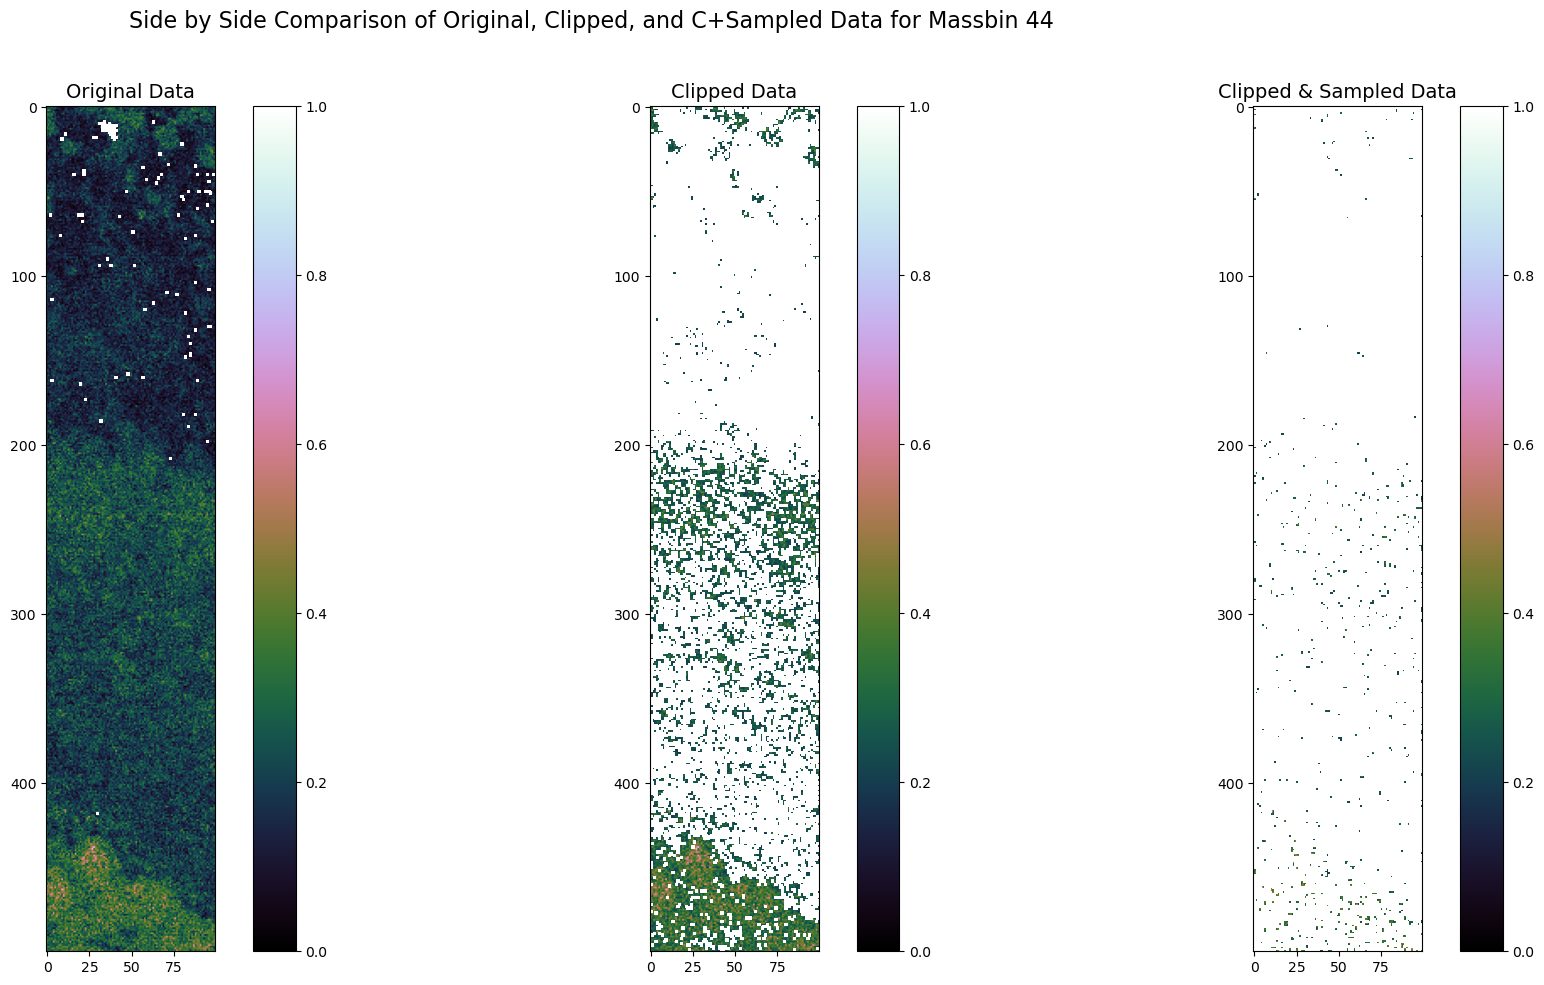

In [94]:
# is there something about mb = 55

sophisticatedSampling(data, 44)

In [10]:
print(p)
print(clippedp)
print(sample_nonzero_values(clippedp, sample_ratio=0.5))

[[0.2021454  0.15862577 0.21249275 0.27248618]
 [0.1520538  0.15205493 0.2763368  0.22069982]
 [0.13592556 0.20528754 0.13634067 0.13618221]
 [0.18468542 0.03697119 0.04988101 0.12956441]]
[[0.2021454  0.         0.21249275 0.27248618]
 [0.         0.         0.2763368  0.22069982]
 [0.         0.20528754 0.         0.        ]
 [0.18468542 0.         0.         0.        ]]
[[0.2021454  0.         0.         0.        ]
 [0.         0.         0.         0.22069982]
 [0.         0.20528754 0.         0.        ]
 [0.18468542 0.         0.         0.        ]]


In [11]:
sclipped = sample_nonzero_values(clippedp, sample_ratio=0.5)
print(sclipped)

[[0.2021454  0.         0.21249275 0.        ]
 [0.         0.         0.2763368  0.22069982]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


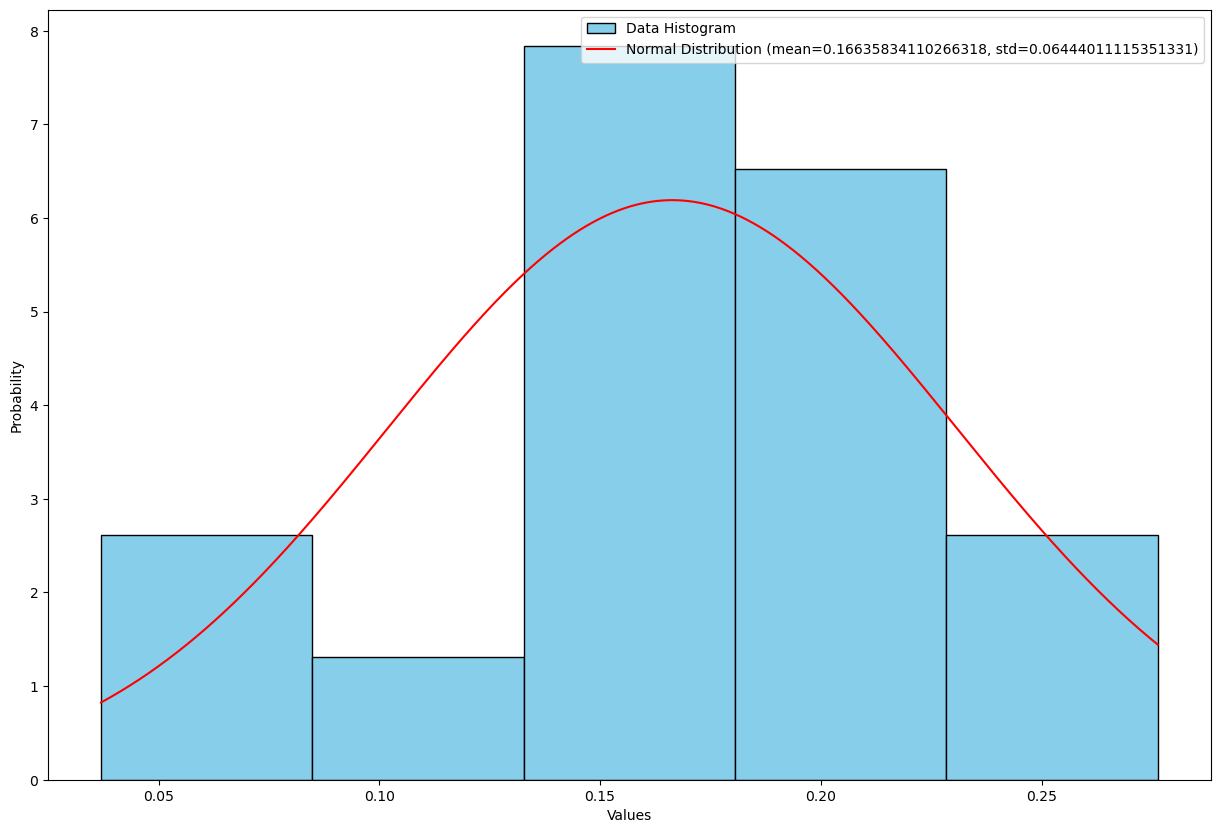

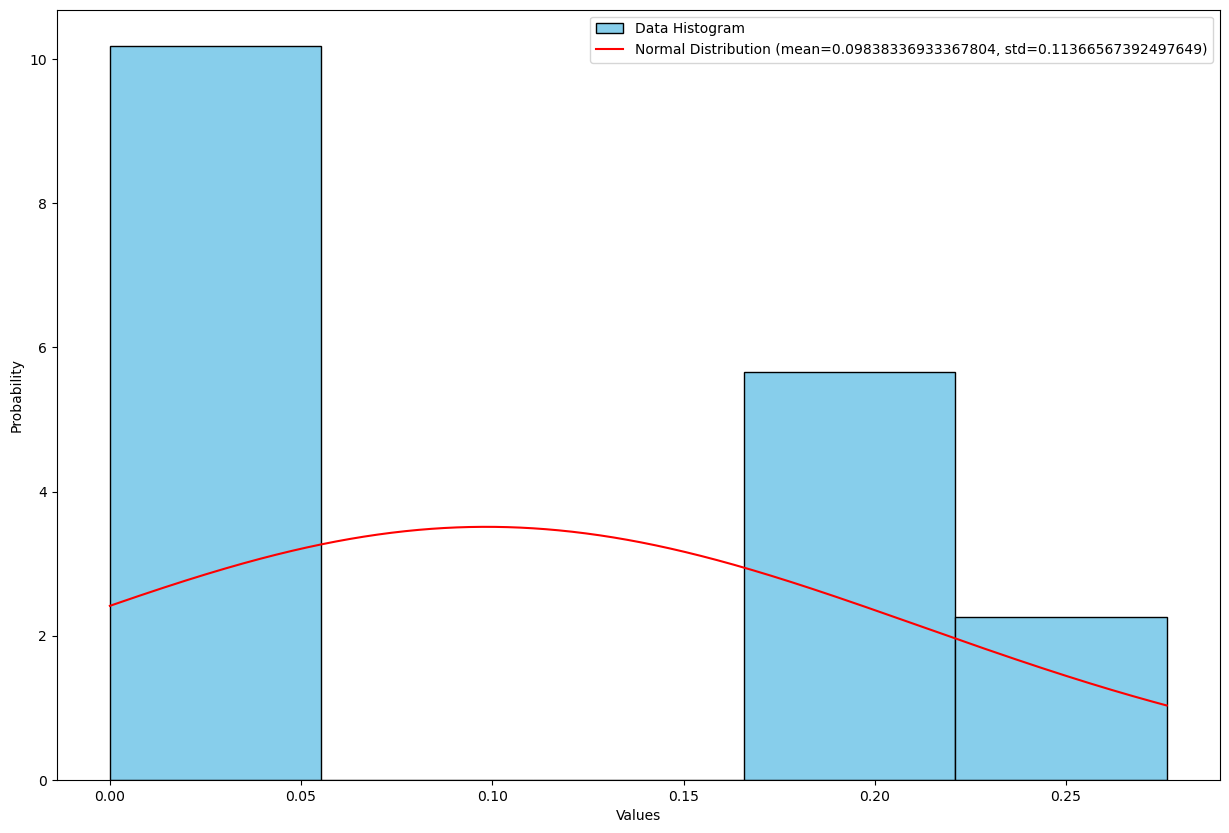

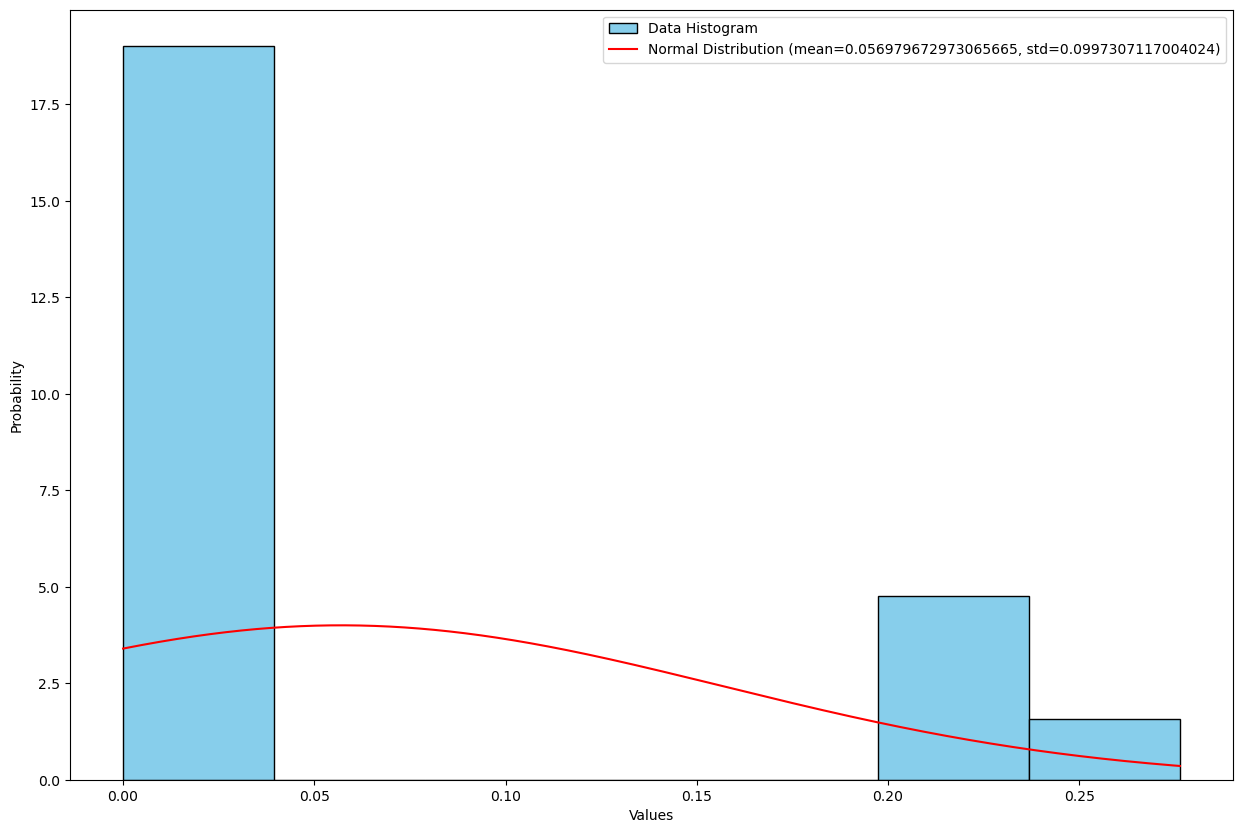

In [12]:
plotHistogram(changeShape(p))
plotHistogram(changeShape(clippedp))
plotHistogram(changeShape(sclipped))

In [9]:
def count_nan(matrix):
    """
    Counts the number of np.nan values in the given matrix.
    
    Args:
    - matrix (numpy array): The matrix in which to count np.nan values.
    
    Returns:
    - count (int): The number of np.nan values in the matrix.
    """
    return np.sum(np.isnan(matrix))


count_nan(sn_data[1,:])

24881

In [10]:
count_nan(sn_data[1,:])/len(sn_data[1,:])

0.49762

In [12]:
X, coords, coords_TF, X_nans = sample_from_matrix_ratio(data, ratio_to_keep=0.6)

In [14]:

def count_zeros(matrix):
    """
    Counts the number of 0 values in the given matrix.
    
    Args:
    - matrix (numpy array): The matrix in which to count 0 values.
    
    Returns:
    - count (int): The number of 0 values in the matrix.
    """
    return np.sum(matrix == 0)